In [1]:
# Dataset destination paths
trainroot='/kaggle/input/deep-learning-for-msc-coursework-2022/train/train'
testroot='/kaggle/input/deep-learning-for-msc-coursework-2022/test'

In [2]:
# Loading libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import optim
from torch.autograd import Variable
import torchvision
import pathlib

In [3]:
# Decide which device to run on
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Using Image folder dataset
# Converting data to torch.FloatTensor
# Loading the training and test datasets

train_set = datasets.ImageFolder(root=trainroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((32,32)),
                               transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
                           ]))

test_set = datasets.ImageFolder(root=testroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((32,32)),
                               transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
                           ]))

train, validation_set = torch.utils.data.random_split(train_set, [1500, 200])


In [5]:
# Obtaining the class types
root=pathlib.Path(trainroot)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Cancer', 'Connective', 'Immune', 'Normal']


In [6]:
# Defining a Convolutional Neural Network 

class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        
        # conv layer (depth from 3 --> 12), 3x3 kernels
        self.conv1=nn.Conv2d(3,12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        
        # pooling layer to reduce dimensions
        self.pool=nn.MaxPool2d(kernel_size=2)

        self.conv2=nn.Conv2d(12,20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
               
        self.conv3=nn.Conv2d(20,20,kernel_size=3,stride=1,padding=1)
        self.relu3=nn.ReLU()
        
        self.conv4=nn.Conv2d(20,24,kernel_size=3,stride=1,padding=1)
        self.relu4=nn.ReLU()
        
        self.conv5=nn.Conv2d(24,32,kernel_size=3,stride=1,padding=1)
        self.bn5=nn.BatchNorm2d(num_features=32)
        self.relu5=nn.ReLU()

        
        self.fc=nn.Linear(in_features=32 * 16 * 16,out_features=num_classes)

        
 #Feed forward function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
        
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
                    
        output=output.view(-1,32*16*16) 
            
        output=self.fc(output)
            
        return output

In [7]:
# initialize the NN
model=ConvNet(num_classes=4).to(device)

In [8]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        # monitor training loss
        loss_train = 0.0
        # training the model
        for imgs, labels in train_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(imgs.to(device))
            # calculate the loss
            loss = loss_fn(outputs, labels.to(device))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def validation_loop(model, device, validation_loader):
    model.eval()
    model = model.to(device)
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))


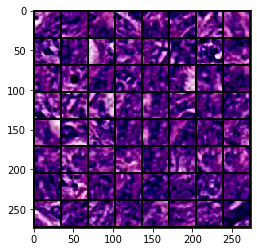

In [9]:
# Initialising the parameters for the training of our networks: optimiser (Stochastic Gradient Descent)
# Data loader to pack your training data in mini-batches.
# Defining a Loss function and optimizer using a Classification Cross-Entropy loss and SGD with momentum.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

lr = 0.0002

# set up a loader object to use minibatches
loader = torch.utils.data.DataLoader(train_set, batch_size = 64)

# also set up a loader for test data, using a single batch
test_loader = torch.utils.data.DataLoader(test_set)
validation_loader = torch.utils.data.DataLoader(validation_set)

# we set the optimiser as Stochastic Gradient Descent for both networks, 
# you could also try Adam
optimizer = optim.SGD(model.parameters(), lr=lr)

# show the first batch of training data (you don't need to understand this code)
images, labels = next(iter(loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

# set the loss function to optimise. Cross Entropy is usually the best for 
# classification
loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1,1,1,1.6]))

In [10]:
# number of epochs to train the model
n_epochs = 20 

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)

2022-03-25 01:02:58.791507 Epoch 1, Training loss 32.622541427612305
2022-03-25 01:03:02.155562 Epoch 2, Training loss 31.51024031639099
2022-03-25 01:03:05.405325 Epoch 3, Training loss 28.873797863721848
2022-03-25 01:03:08.594273 Epoch 4, Training loss 26.580690801143646
2022-03-25 01:03:11.806733 Epoch 5, Training loss 24.718295693397522
2022-03-25 01:03:15.014621 Epoch 6, Training loss 23.18091920018196
2022-03-25 01:03:18.178776 Epoch 7, Training loss 21.870990127325058
2022-03-25 01:03:21.395449 Epoch 8, Training loss 20.726842880249023
2022-03-25 01:03:24.797613 Epoch 9, Training loss 19.714296877384186
2022-03-25 01:03:27.956094 Epoch 10, Training loss 18.803752064704895
2022-03-25 01:03:31.224516 Epoch 11, Training loss 17.980956584215164
2022-03-25 01:03:34.472253 Epoch 12, Training loss 17.228794753551483
2022-03-25 01:03:37.691720 Epoch 13, Training loss 16.538170158863068
2022-03-25 01:03:40.894450 Epoch 14, Training loss 15.90199339389801
2022-03-25 01:03:44.184606 Epoch

In [11]:
# Validation
validation_loop(model = model, device = device, validation_loader = validation_loader)


Test set: Average loss: 0.8825, Accuracy: 97/200 (48%)



In [12]:
# Capturing 
import csv
pred = []
d = {}
for imgs, labels in test_loader:
  imgs, labels = imgs.to(device), imgs.to(device)
  outputs = model(imgs)
  pred.append(outputs.argmax(dim=1, keepdim=True))

for i in range(len(test_set)):
  d[test_set.imgs[i][0].split("/")[-1]] = classes[pred[i]]
with open('test.csv', 'w', newline='') as csvfile:
    header_key = ['Id', 'Type']
    new_val = csv.DictWriter(csvfile, fieldnames=header_key)

    new_val.writeheader()
    for new_k in d:
        new_val.writerow({'Id': new_k, 'Type': d[new_k]})